This is a copy of my public kaggle kernel: https://www.kaggle.com/joatom/arc-exploring-with-unet.

This notebook is a Fork of https://www.kaggle.com/inversion/abstraction-and-reasoning-starter-notebook.
# [ARC] Exploring with UNet
The assumption in this notebook is that some of the task can be tackled like an Segemntation task, where `output` behaves like a mask with 10 categories. Therefore I try to apply a unet to check this assumption.

The given tasks in the json files are split into `train` and `test` arrays. My validation set is build upon the `test` arrays, so I'll refere to them as `valid` throughout the notebook.  

## Credits
Elements of this notebooks are taken from:

- Function to plot task, loading tasks: https://www.kaggle.com/inversion/abstraction-and-reasoning-starter-notebook

Please visit the notebooks and upvote if you like them.

In [1]:
import numpy as np
import pandas as pd

import os, shutil
import json
from pathlib import Path
import sys
from datetime import datetime

import torch.nn.functional as F
from fastai.vision import *
from fastai.utils.mod_display import *
from torchvision import utils

import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from scipy import stats
from sklearn import metrics

from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from fastai.utils.mod_display import *

from PIL import Image

In [2]:
kaggle_input_path = '/kaggle/input'

kaggle_arc_path = '/arc/input'


for dirname, _, filenames in os.walk(kaggle_input_path):
    print(dirname)

/kaggle/input
/kaggle/input/abstraction-and-reasoning-challenge
/kaggle/input/abstraction-and-reasoning-challenge/training
/kaggle/input/abstraction-and-reasoning-challenge/test
/kaggle/input/abstraction-and-reasoning-challenge/evaluation


In [3]:
from pathlib import Path

data_path = Path(kaggle_input_path+'/abstraction-and-reasoning-challenge/')
training_path = data_path / 'training'
evaluation_path = data_path / 'evaluation'
test_path = data_path / 'test'

The `training` folder has 400 JSON tasks. `training_tasks` lists some of them.

In [4]:
training_tasks = ['ce9e57f2', '868de0fa', 'b6afb2da', 
                  'db3e9e38', '3618c87e', 'bb43febb', 
                  '543a7ed5', '08ed6ac7', '6f8cd79b', 
                  'b1948b0a', '4258a5f9', '00d62c1b',
                  '1bfc4729',
                  '25ff71a9', '321b1fc6', '32597951',
                  '36fdfd69', '3aa6fb7a', '3bdb4ada',
                  '3befdf3e', '4093f84a', '444801d8',
                  '4612dd53', '50cb2852', '60b61512',
                  '67385a82', '6773b310', '694f12f3',
                  '6c434453', '6cf79266', '6d75e8bb',
                  '6e82a1ae']

## Function to plot task
Modified version of plot_task from https://www.kaggle.com/inversion/abstraction-and-reasoning-starter-notebook.
Added white (#FFFFFF) as additional color to fill borders.

In [5]:
cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25' ,'#FFFFFF'])

cnorm = colors.Normalize(vmin=0, vmax=10) #vmax=9

def plot_task(taskname, train_idx=0, test_index=0, pred_imgs=[], max_train = -1):
    """
    Plots the first train and test pairs of a specified task,
    using same color scheme as the ARC app
    """
    
    # loading tasks
    task_file = str(training_path / (taskname+'.json'))
    with open(task_file, 'r') as f:
        task = json.load(f)
    
    
    if len(pred_imgs) == 0:
        rows = 2
    else:
        rows = 4
    
    if max_train == -1:
        # show all
        max_train = len(task['train'])  
    
    fig, axs = plt.subplots(rows, (max_train+len(task['test']))*2, figsize=(15,2*rows))
    offset = 0
    for i in range(max_train):
        axs[0, i*2].imshow(task['train'][i]['input'], cmap=cmap, norm=cnorm)
        axs[0, i*2].axis('off')
        axs[0, i*2].set_title('Train In '+str(i))
        
        im = Image.open(f'{kaggle_arc_path}/temp/input/{taskname}/train_{taskname}_'+str(i)+'.png')
        axs[1, i*2].imshow(im, cmap=cmap, norm=cnorm)
        axs[1, i*2].set_title('Train In '+str(i)+' image')
        axs[1, i*2].axis('off')
        
        axs[0, i*2+1].imshow(task['train'][i]['output'], cmap=cmap, norm=cnorm)
        axs[0, i*2+1].axis('off')
        axs[0, i*2+1].set_title('Train Out '+str(i))
        
        im = Image.open(f'{kaggle_arc_path}/temp/output/{taskname}/train_{taskname}_'+str(i)+'.png')
        axs[1, i*2+1].imshow(im, cmap=cmap, norm=cnorm)
        axs[1, i*2+1].set_title('Train Mask '+str(i)+' image')
        axs[1, i*2+1].axis('off')
        
        offset+=2
        
    for i in range(len(task['test'])):
        j=i*2+offset
        axs[0, j].imshow(task['test'][i]['input'], cmap=cmap, norm=cnorm)
        axs[0, j].set_title('Valid In '+str(i))
        axs[0, j].axis('off')
        
        im = Image.open(f'{kaggle_arc_path}/temp/input/{taskname}/valid_{taskname}_'+str(i)+'.png')
        axs[1, j].imshow(im, cmap=cmap, norm=cnorm)
        axs[1, j].set_title('Valid In '+str(i)+' img')
        axs[1, j].axis('off')
        
        axs[0, j+1].imshow(task['test'][i]['output'], cmap=cmap, norm=cnorm)
        axs[0, j+1].set_title('Valid Out '+str(i))
        axs[0, j+1].axis('off')
        
        im = Image.open(f'{kaggle_arc_path}/temp/output/{taskname}/valid_{taskname}_'+str(i)+'.png')
        axs[1, j+1].imshow(im, cmap=cmap, norm=cnorm)
        axs[1, j+1].set_title('Valid Mask '+str(i)+' image')
        axs[1, j+1].axis('off')
    
    if rows == 4:
        for p, pred_img in enumerate(pred_imgs):
            y = -2*(len(pred_imgs))+2*p+1
            axs[2, y].imshow(pred_img, cmap=cmap, norm=cnorm)
            axs[2, y].set_title('Pred img')
            #for i in range(len(task['test'])+max_train*2):
            #    axs[2, i ].axis('off')

            rs_pred_img = resize_unpad(pred_img,task_info[taskname]['max_xy'],
                                       np.round(task_info[taskname]['test_in_shapes'][p] * 
                                                task_info[taskname]['avg_train_shape_factor']).astype('uint8')
                                      )
            acc = metrics.accuracy_score(np.array(task['test'][p]['output']).reshape(1,-1)[0], rs_pred_img.reshape(1,-1)[0])
        
            axs[3, y].imshow(rs_pred_img, cmap=cmap, norm=cnorm)
            axs[3, y].set_title(f'Pred img croped and rescaled (acc: {acc:.4f})')
        
        for i in range((len(task['test'])+max_train)*2):
            axs[2, i].axis('off')
            axs[3, i].axis('off')
        
        #acc = metrics.accuracy_score(np.array(task['test'][0]['output']).reshape(1,-1)[0], rs_pred_img.reshape(1,-1)[0])
        #print(f"Accuracy: {acc}")
                
    plt.tight_layout()
    plt.show()

## Functions to prepare task images

For convenience the arrays are safed as images, so that the Fastai Dataloader for Segmentation can easily be applied without modification.

In [6]:
def task_sample_arr(taskname, test_train = 'train', in_out = 'input', idx = 0):
    task_file = str(training_path / (taskname+'.json'))
    with open(task_file, 'r') as f:
        task = json.load(f)
    
    return np.array(task[test_train][idx][in_out])


def pad_to_xy(a, max_xy, color = 10):
    
    ''' Center and 0-pad np.array to max_xy-size '''

    y, x = a.shape
    (max_x, max_y) = max_xy 
    
    y0 = (max_y-y)//2 #0
    y1 = (max_y-y)-(max_y-y)//2 #max_xy[1]-y
    x0 = (max_x-x)//2 #0
    x1 = (max_x-x)-(max_x-x)//2 #max_xy[0]-x
    
    return np.pad(a, ((y0, y1), (x0, x1)), 'constant', constant_values=(color, color)) #F.pad(t, (0,max_xy[0]-x, 0, max_xy[1]-y), mode='constant')


def unpad_xy(img, max_xy=(16,16), org_xy=(15,15)):
    x_start = (max_xy[0]-org_xy[1])//2
    x_end = x_start + org_xy[1]

    y_start = (max_xy[1]-org_xy[0])//2
    y_end = y_start + org_xy[0]
    
    return img[y_start:y_end,x_start:x_end]


def resize_unpad(img, max_xy=(16,16), org_xy=(15,15)):
    t=Image.fromarray(img.astype('uint8'))

    t = np.asarray(t.resize(max_xy, Image.NEAREST))

    return unpad_xy(t,max_xy,org_xy)

In [7]:
def export_max_padded(task, taskname):
    
    ''' Get max x and max y size of all task images. 
        Center and pad task images to max size
        Save arrays as images to /temp folder.
    '''
    
    os.makedirs(f'{kaggle_arc_path}/temp/input/{taskname}')
    os.makedirs(f'{kaggle_arc_path}/temp/output/{taskname}')
        
    max_xy=(0,0)
    max_x=0
    max_y=0
    
    train_in=[]
    train_out=[]
    valid_in=[]
    valid_out=[]
    all_train_colors=[]
    
    num_train = 0
    num_valid = 0
    
    # to array and get max_x, max_y
    for i, tsk in enumerate(task['train']):
        t = np.array(tsk['input']).astype('uint8')
        train_in.append(t)
        all_train_colors+=t.reshape(1,-1).tolist()
        max_x = max(t.shape[1], max_x)
        max_y = max(t.shape[0], max_y)
        t = np.array(tsk['output']).astype('uint8')
        train_out.append(t)
        all_train_colors+=t.reshape(1,-1).tolist()
        max_x = max(t.shape[1], max_x)
        max_y = max(t.shape[0], max_y)
        
    for i, tsk in enumerate(task['test']):
        t = np.array(tsk['input']).astype('uint8')
        valid_in.append(t)
        max_x = max(t.shape[1], max_x)
        max_y = max(t.shape[0], max_y)
        t = np.array(tsk['output']).astype('uint8')
        valid_out.append(t)
        max_x = max(t.shape[1], max_x)
        max_y = max(t.shape[0], max_y)
        
        max_xy=(max([int(max_x//0.7),16]), max([int(max_y//0.7),16]))
        #max_xy=(32,32)
        #print(f'max_xy: {max_xy}')
    
    #flatten
    all_train_colors = [i for lst in all_train_colors for i in lst]
    
    bgcolor = stats.mode(all_train_colors,axis=None)[0]  # 0
    framecolor = bgcolor
    
    # pad and save
    train_in_shapes = []
    for i, t in enumerate(train_in):
        train_in_shapes.append(t.shape)
        tp = pad_to_xy(t, reversed(tuple(np.add(t.shape,(2,2)))), framecolor) # 0
        tp = pad_to_xy(tp, max_xy) #t
        im = Image.fromarray(tp)
        im.save(f'{kaggle_arc_path}/temp/input/{taskname}/train_{taskname}_'+str(i)+'.png')
        num_train += 1
    train_out_shapes = []
    for i, t in enumerate(train_out):
        train_out_shapes.append(t.shape)
        tp = pad_to_xy(t, reversed(tuple(np.add(t.shape,(2,2)))), framecolor)
        tp = pad_to_xy(tp, max_xy)
        im = Image.fromarray(tp)
        im.save(f'{kaggle_arc_path}/temp/output/{taskname}/train_{taskname}_'+str(i)+'.png')
        
    valid_shapes = []
    for i, t in enumerate(valid_in):
        valid_shapes.append(t.shape)
        tp = pad_to_xy(t, reversed(tuple(np.add(t.shape,(2,2)))), framecolor)
        tp = pad_to_xy(tp, max_xy)
        im = Image.fromarray(tp)
        im.save(f'{kaggle_arc_path}/temp/input/{taskname}/valid_{taskname}_'+str(i)+'.png')
        num_valid += 1
    for i, t in enumerate(valid_out):
        #print(f'shape of validation output: {t.shape}')
        tp = pad_to_xy(t, reversed(tuple(np.add(t.shape,(2,2)))), framecolor)
        tp = pad_to_xy(tp, max_xy)
        im = Image.fromarray(tp)
        im.save(f'{kaggle_arc_path}/temp/output/{taskname}/valid_{taskname}_'+str(i)+'.png')

        
    return {'num_train': num_train, 
            'num_test': num_valid, 
            'max_xy': max_xy, 
            'test_in_shapes': valid_shapes, # in shapes of test
            'avg_train_shape_factor': np.mean(np.array(train_out_shapes)/np.array(train_in_shapes), axis = 0), # avg factor for train in shape to train outshape 
            'bgcolor': bgcolor}


# Prepare images

0. Example task ce9e57f2:


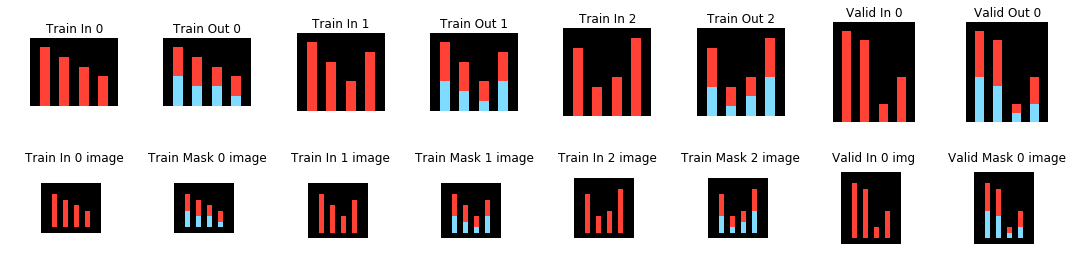

In [8]:
# create temp folder
if  os.path.exists(kaggle_arc_path + '/temp'):
    shutil.rmtree(kaggle_arc_path + '/temp');

os.makedirs(kaggle_arc_path + '/temp/input')
os.makedirs(kaggle_arc_path + '/temp/output')

# create temp folder
#if  os.path.exists(kaggle_input_path + '/temp'):
#    shutil.rmtree(kaggle_input_path + '/temp');

#os.makedirs(kaggle_input_path + '/temp/input')
#os.makedirs(kaggle_input_path + '/temp/output')

task_info={}

for i, taskname in enumerate(training_tasks):
    # loading tasks
    task_file = str(training_path / (taskname+'.json'))
    with open(task_file, 'r') as f:
        task = json.load(f)
    
    # save train and validation arrays as images
    # all images are padded to the max x and y size of the current task arrays
    num_tt = export_max_padded(task, taskname)
    task_info[taskname] = num_tt
    #print(f'Task info: {task_info}')
    ## show an example
    if i==0:
        print(str(i)+'. Example task '+taskname + ':')
        plot_task(taskname)#, max_train=2)

plt.show() 

# Modeling
Applying the UNet basicly follows the tutorial (https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson3-camvid.ipynb). 

## Data
Since there are only view train samples, augmentation is used to generate more samples with increasing sice of epochs.

In [9]:
get_y_fn = lambda x: f'{kaggle_arc_path}/temp/output/{x.stem.split("_")[1]}/{x.stem}{x.suffix}'
    
def data(task = training_tasks[0]):
    return (SegmentationItemList.from_folder(f'{kaggle_arc_path}/temp/input/{task}')
        #.split_by_idx(valid_idx=[i for i in range(len(task['train']), len(task['train'])+len(task['test']))])
        .split_by_files(valid_names = [f'valid_{task}_{i}.png' for i in range(task_info[task]['num_test'])])
        .label_from_func(get_y_fn, classes = np.array([str(i) for i in range(11)])) #range(10)
        .transform(get_transforms(), tfm_y=True, size=256, padding_mode = 'border')  #256
        .databunch(bs=1)
        .normalize(imagenet_stats)
       )


In [10]:
# Example
#data(training_tasks[0]).show_batch(rows=2, figsize=(6, 6), alpha=1) #, cmap=cmap, norm=cnorm)

## Model
The pretrained model gets extended by a SelfAttention-Block (see Module SAI), which works in this experiment better then the one which could be activated as a learner parameter.

In [11]:

class SAI(nn.Module):
    ''' SelfAttention with Identity '''
    
    def __init__(self, nf):
        super(SAI, self).__init__()
        
        self.sa = PooledSelfAttention2d(nf)
        self.bn = nn.BatchNorm2d(nf)
        self.do = nn.Dropout(0.4)
        
        
    def forward(self, x):
        ident = x
        out = self.sa(x)
        out = ident + out
        
        out = self.do(self.bn(out)) #
        
        return out


In [12]:
def learn(task = training_tasks[0], epochs = 150, runs = 2, lr = 5e-5):
    print(f'Task {task} start..')
    lrn = unet_learner(data(task), models.resnet18, blur = True, bottle = True) #, wd=1e-3 #bottle off
    
    lrn.model[0][4].add_module('sai0_4', SAI(64)) 
    lrn.model[0][5].add_module('sai0_5', SAI(128))

    lrn.model[7].shuf.blur.add_module('sai7', SAI(512)) 
    lrn.model[8].blur.add_module('sai8', SAI(384)) 
    
    lrn.model = lrn.model.cuda()
        
    for i in range(runs):
        # Disable progressbar from https://forums.fast.ai/t/how-to-run-without-progress-bar/29875/6
        with progress_disabled_ctx(lrn) as lrn:
            lrn.fit_one_cycle(epochs, slice(lr))
        print(f'run #{i} done')
  
    return lrn

Task ce9e57f2 start..


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



run #0 done
run #1 done


Accuracy ce9e57f2_0: 0.9696969696969697


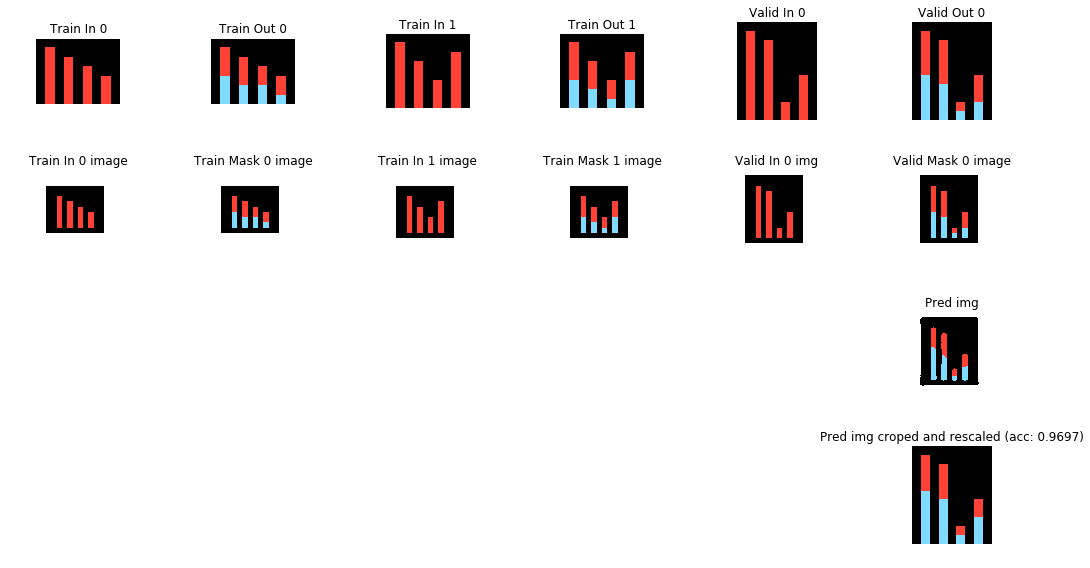

Task 868de0fa start..
run #0 done
run #1 done


Accuracy 868de0fa_0: 0.695


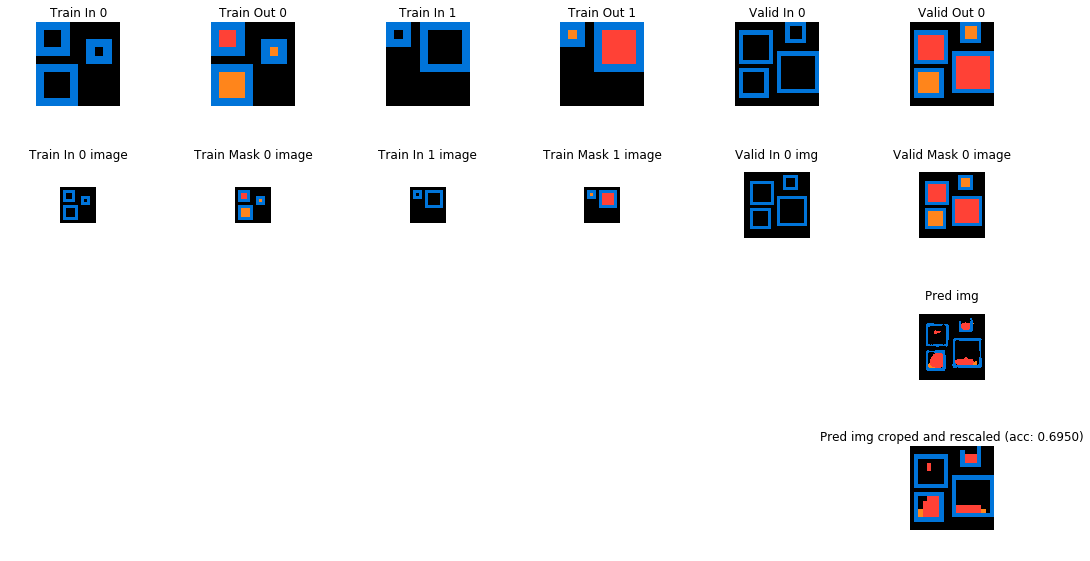

Task b6afb2da start..
run #0 done
run #1 done


Accuracy b6afb2da_0: 1.0


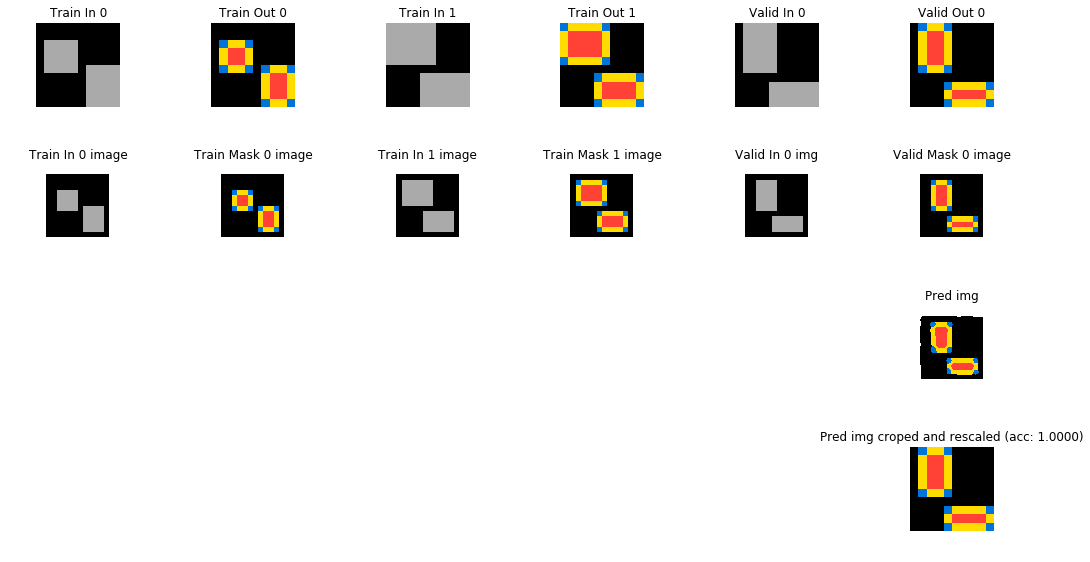

Task db3e9e38 start..
run #0 done
run #1 done


Accuracy db3e9e38_0: 0.7654320987654321


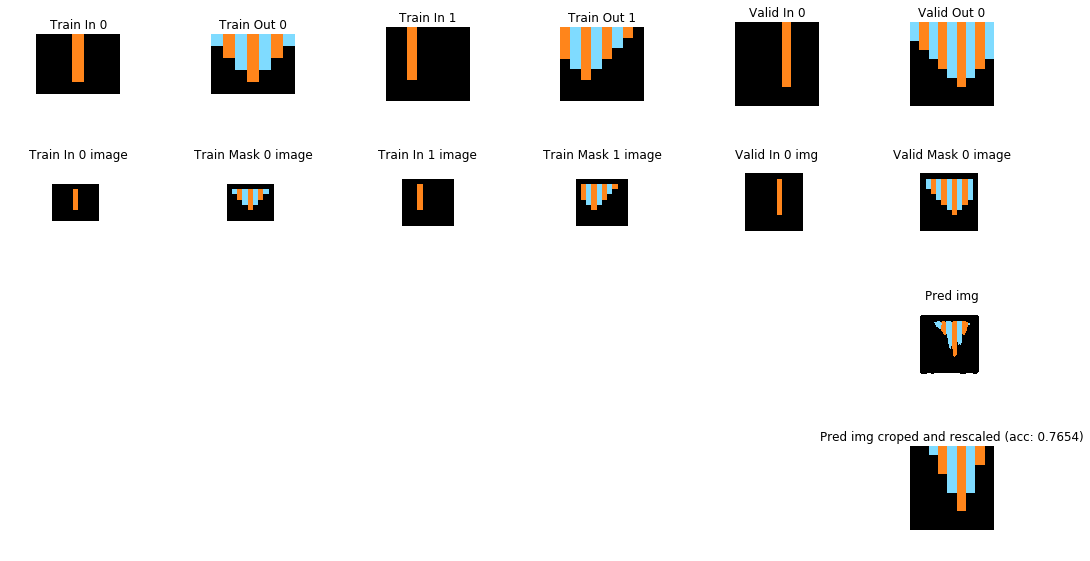

Task 3618c87e start..
run #0 done
run #1 done


Accuracy 3618c87e_0: 1.0


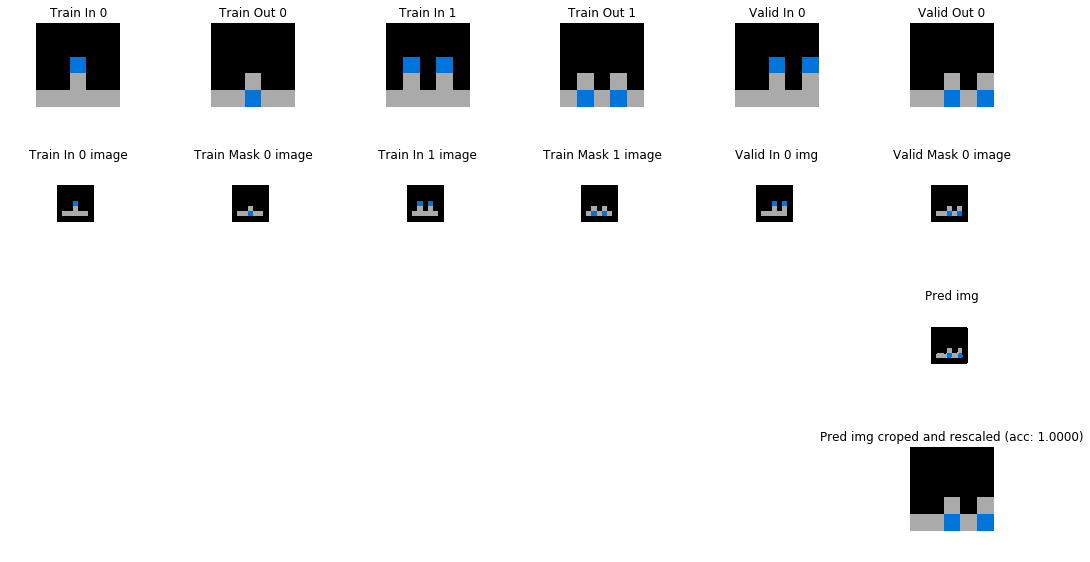

Task bb43febb start..
run #0 done
run #1 done


Accuracy bb43febb_0: 1.0


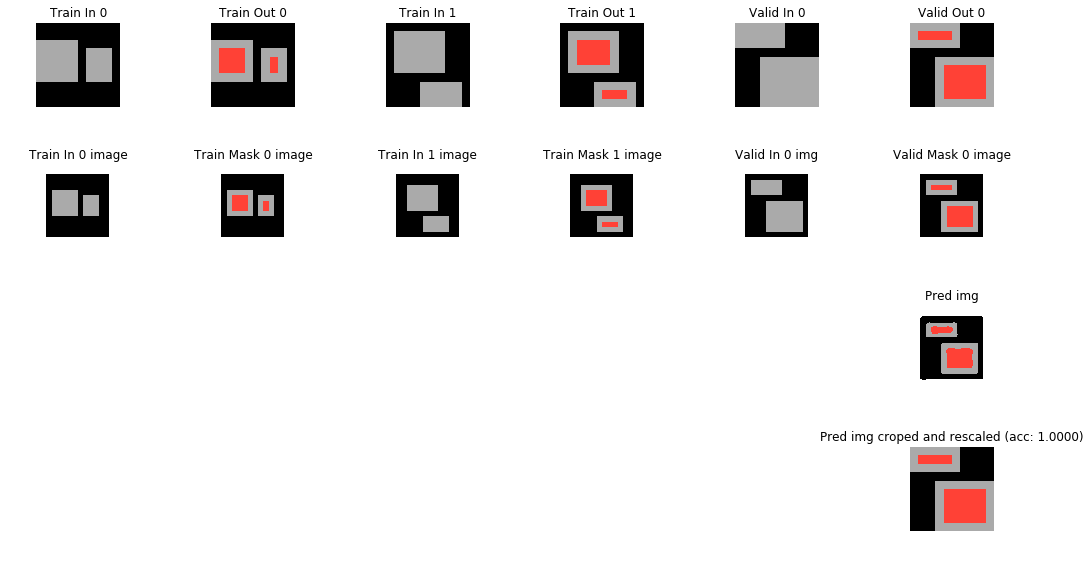

Task 543a7ed5 start..
run #0 done
run #1 done


Accuracy 543a7ed5_0: 1.0


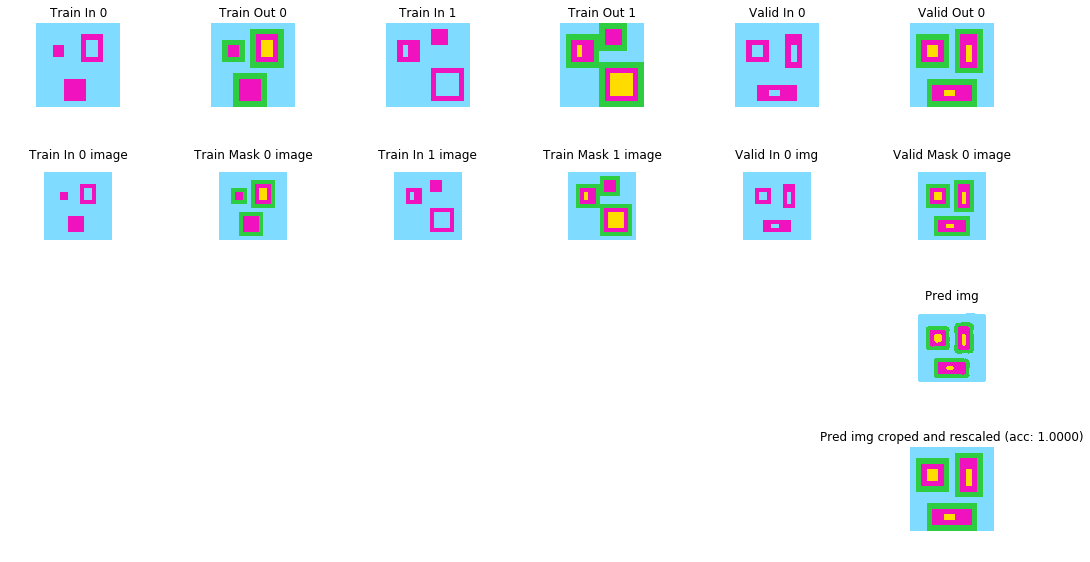

Task 08ed6ac7 start..
run #0 done
run #1 done


Accuracy 08ed6ac7_0: 0.8395061728395061


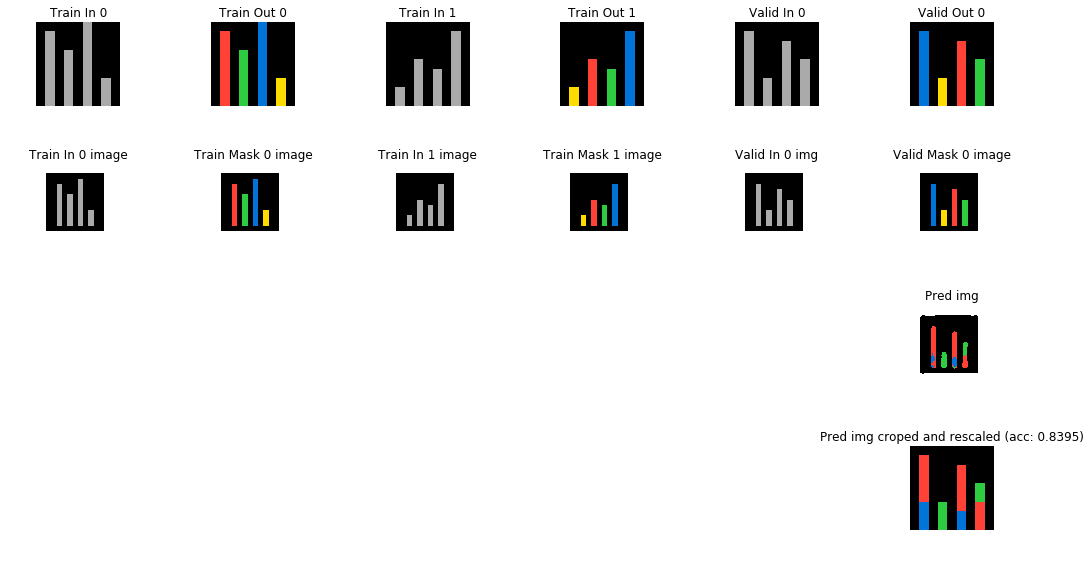

Task 6f8cd79b start..
run #0 done
run #1 done


Accuracy 6f8cd79b_0: 1.0


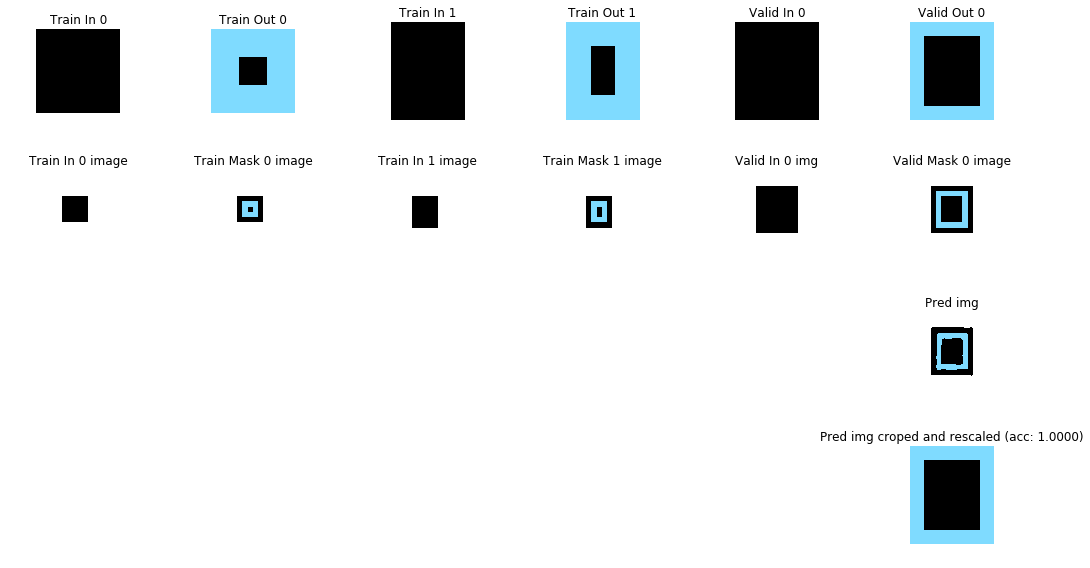

Task b1948b0a start..
run #0 done
run #1 done


Accuracy b1948b0a_0: 0.9375


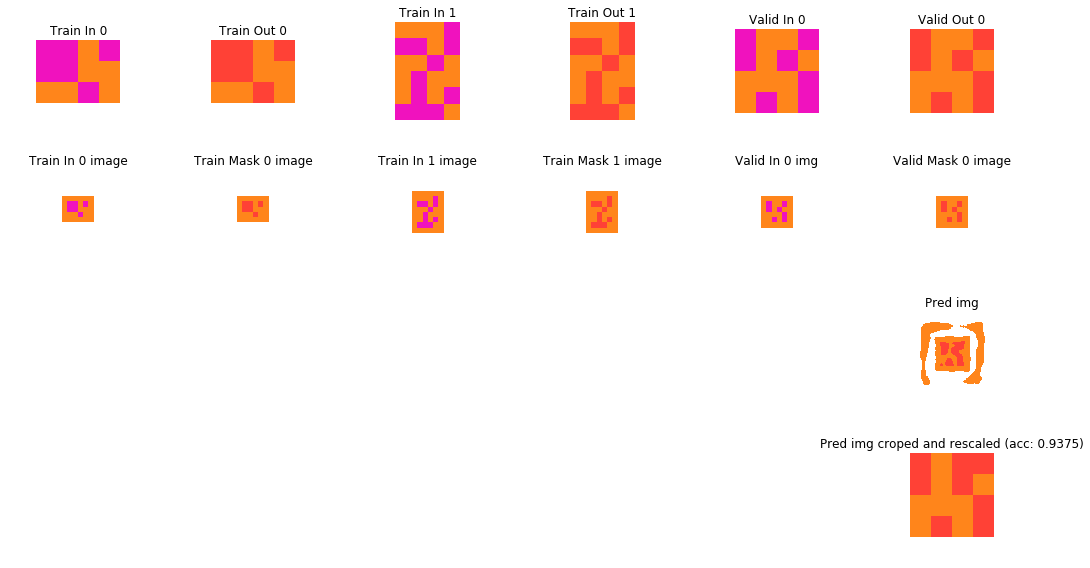

Task 4258a5f9 start..
run #0 done
run #1 done


Accuracy 4258a5f9_0: 1.0


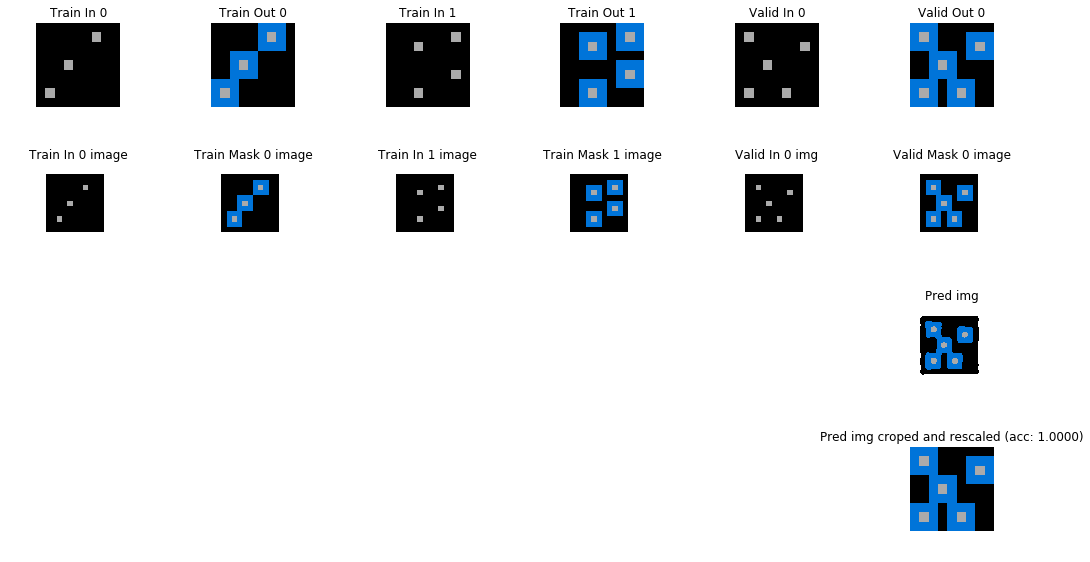

Task 00d62c1b start..
run #0 done
run #1 done


Accuracy 00d62c1b_0: 0.9775


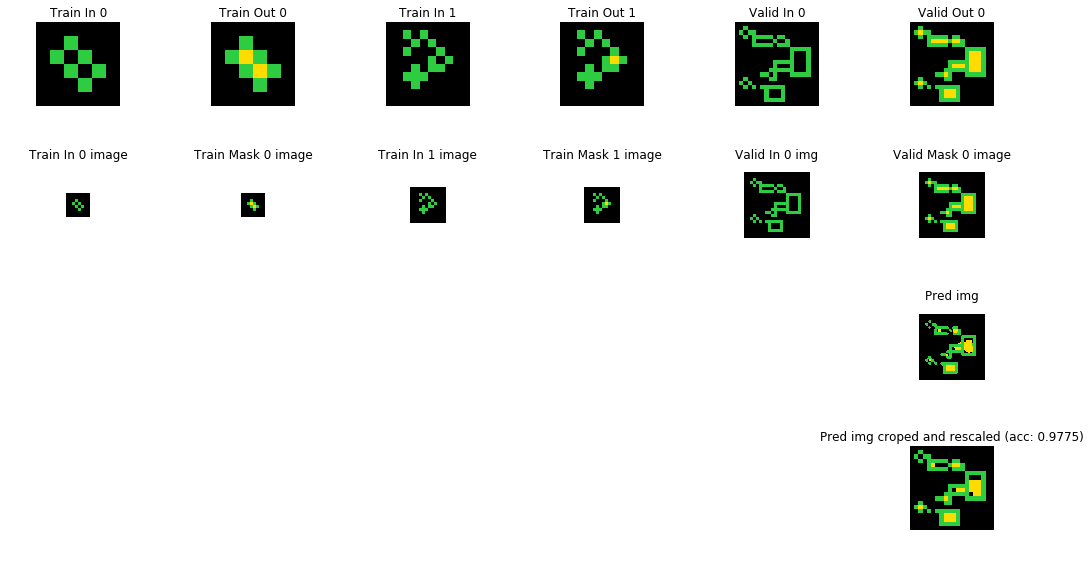

Task 1bfc4729 start..
run #0 done
run #1 done


Accuracy 1bfc4729_0: 0.48


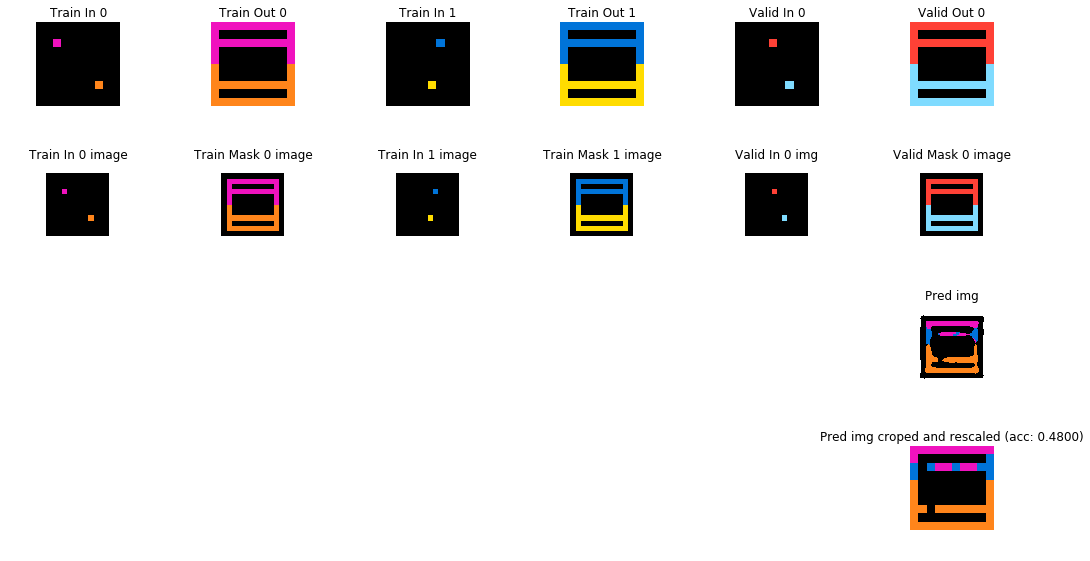

Task 25ff71a9 start..
run #0 done
run #1 done


Accuracy 25ff71a9_0: 1.0
Accuracy 25ff71a9_1: 0.8888888888888888


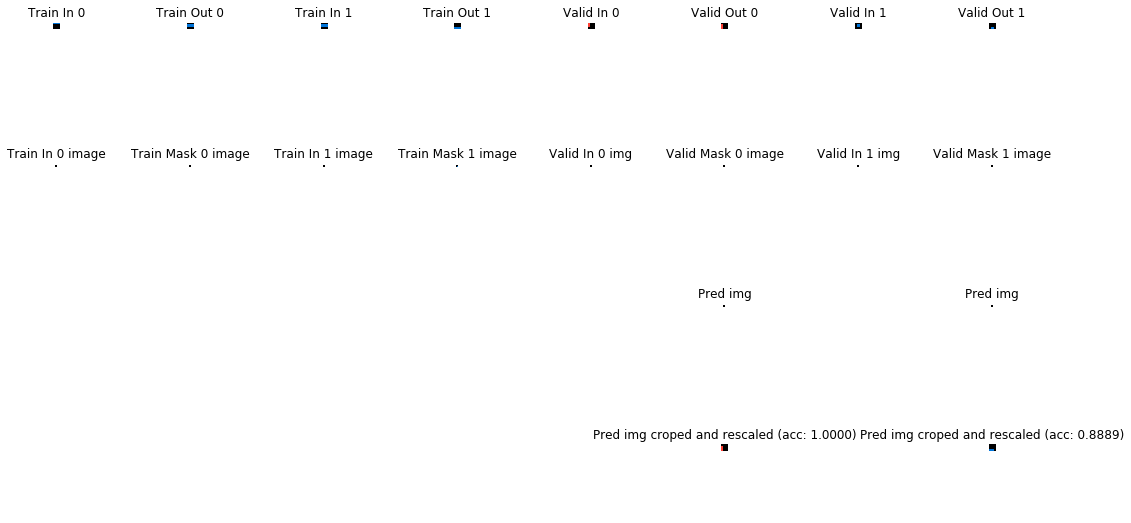

Task 321b1fc6 start..
run #0 done
run #1 done


Accuracy 321b1fc6_0: 0.79


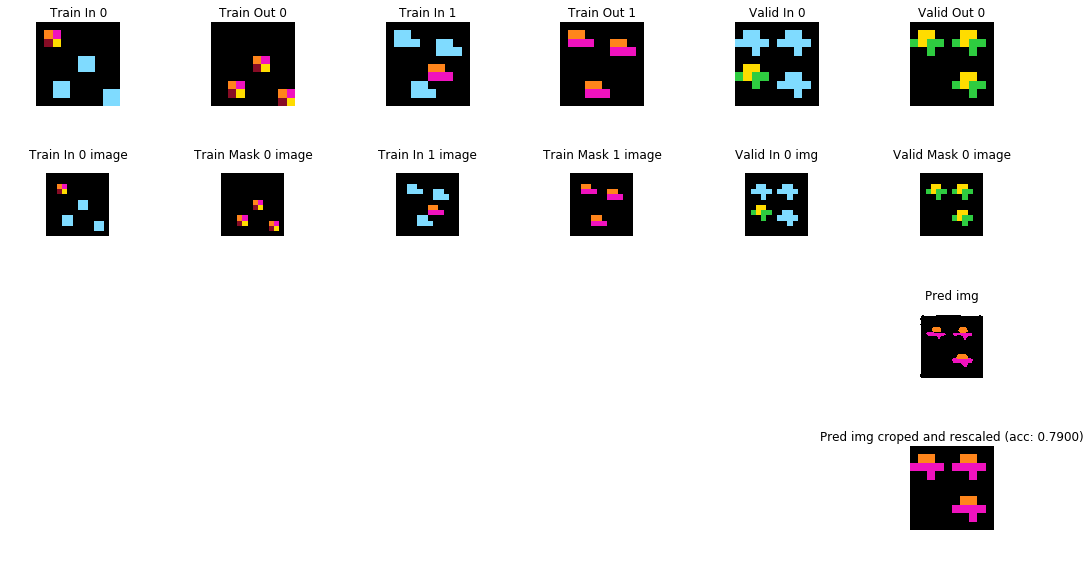

Task 32597951 start..
run #0 done
run #1 done


Accuracy 32597951_0: 0.9965397923875432


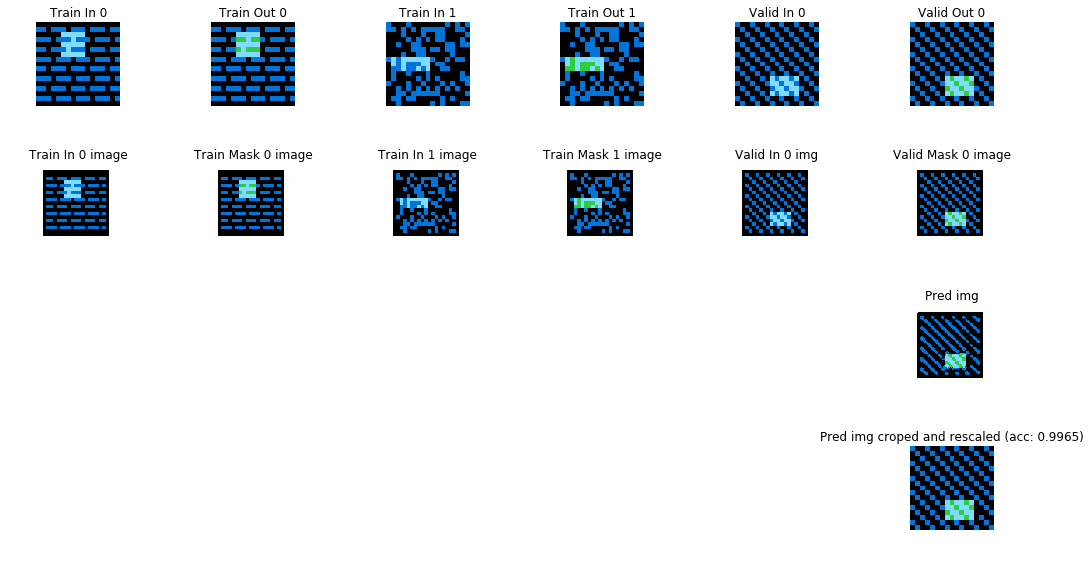

Task 36fdfd69 start..
run #0 done
run #1 done


Accuracy 36fdfd69_0: 0.46405228758169936


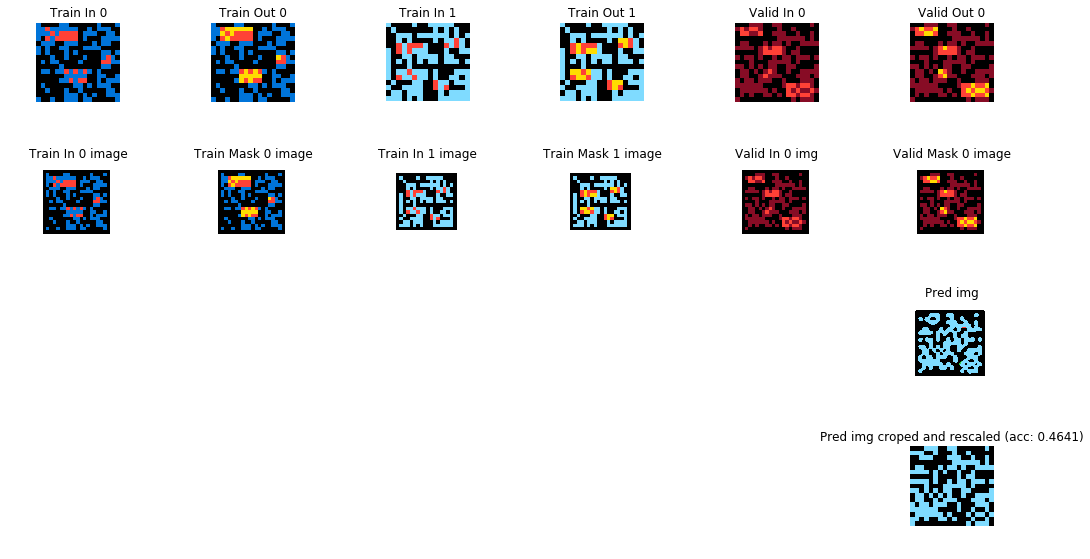

Task 3aa6fb7a start..
run #0 done
run #1 done


Accuracy 3aa6fb7a_0: 0.9387755102040817


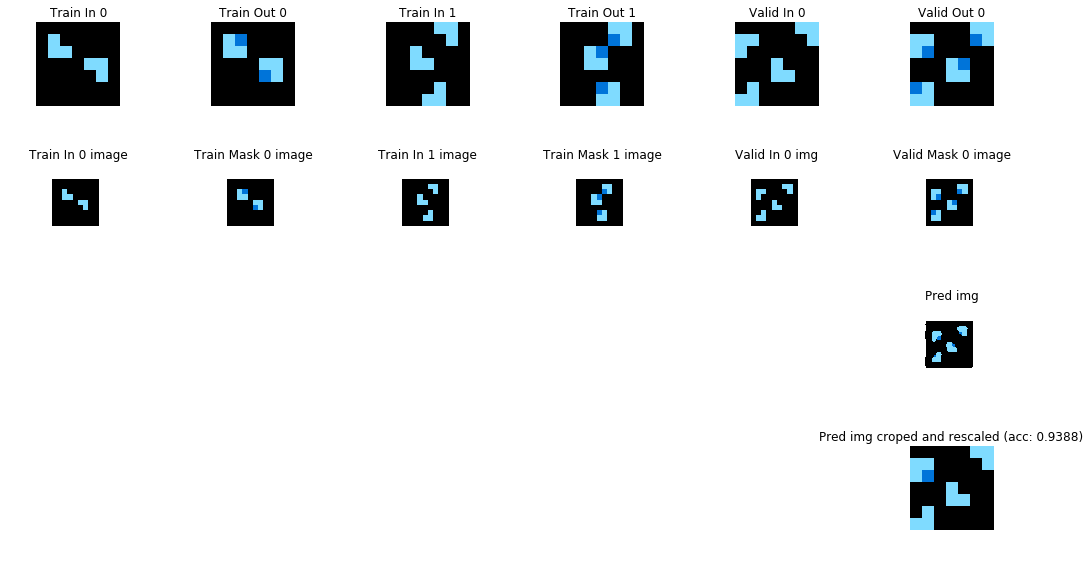

Task 3bdb4ada start..
run #0 done
run #1 done


Accuracy 3bdb4ada_0: 0.740909090909091


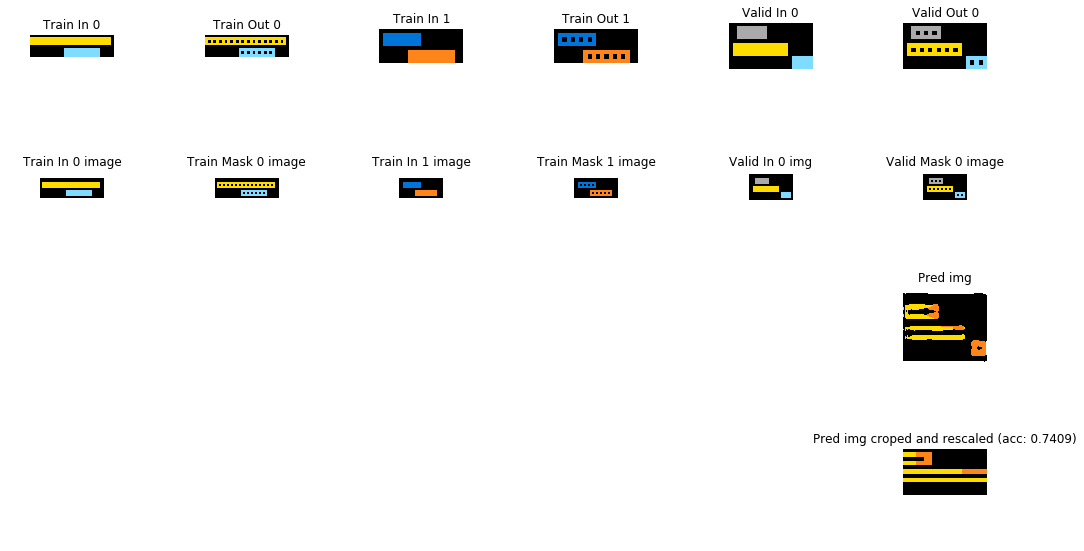

Task 3befdf3e start..
run #0 done
run #1 done


Accuracy 3befdf3e_0: 0.5208333333333334


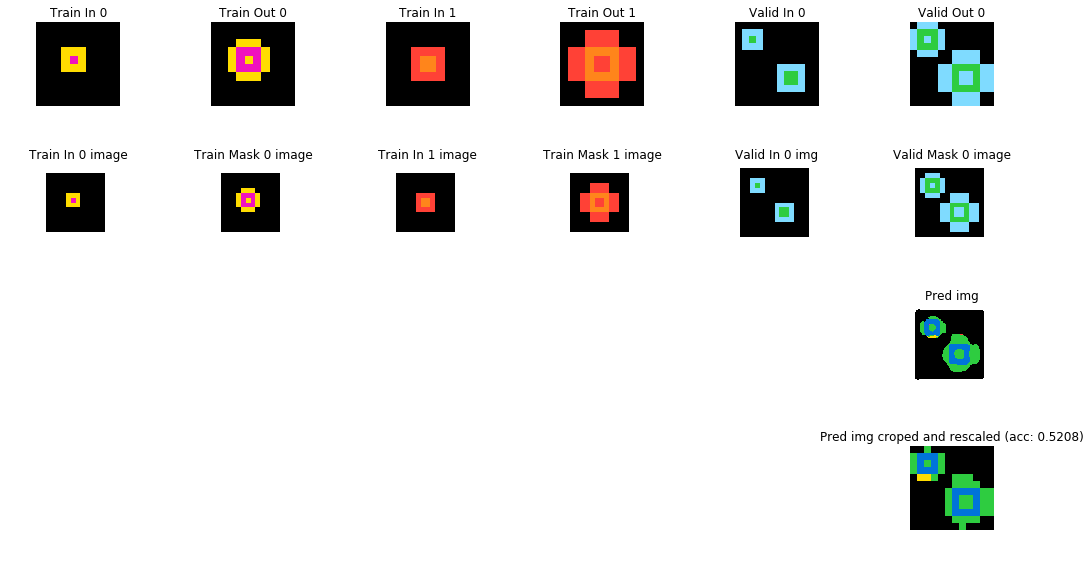

Task 4093f84a start..
run #0 done
run #1 done


Accuracy 4093f84a_0: 0.9540816326530612


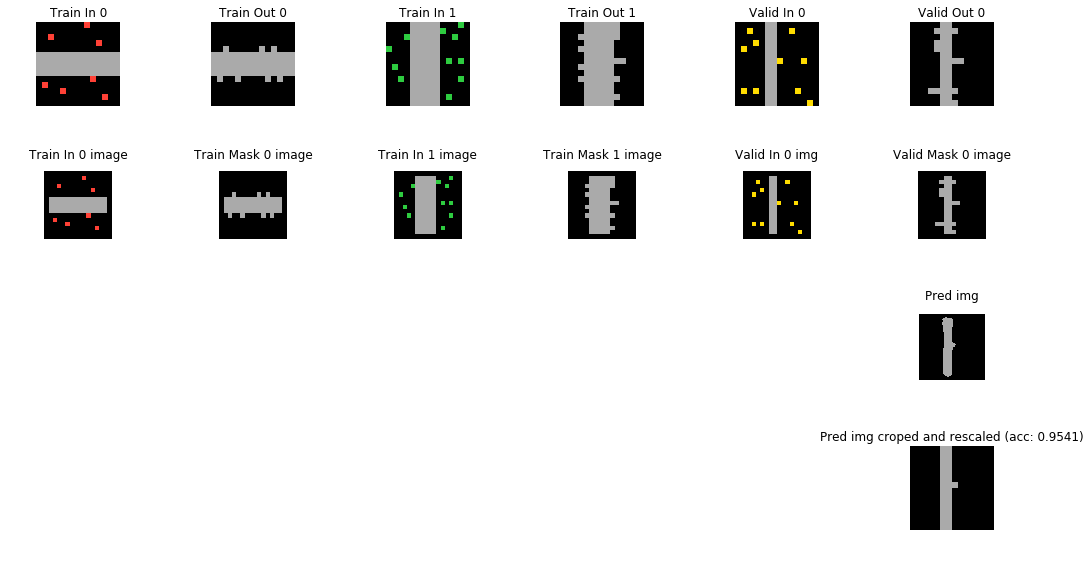

Task 444801d8 start..
run #0 done
run #1 done


Accuracy 444801d8_0: 0.74


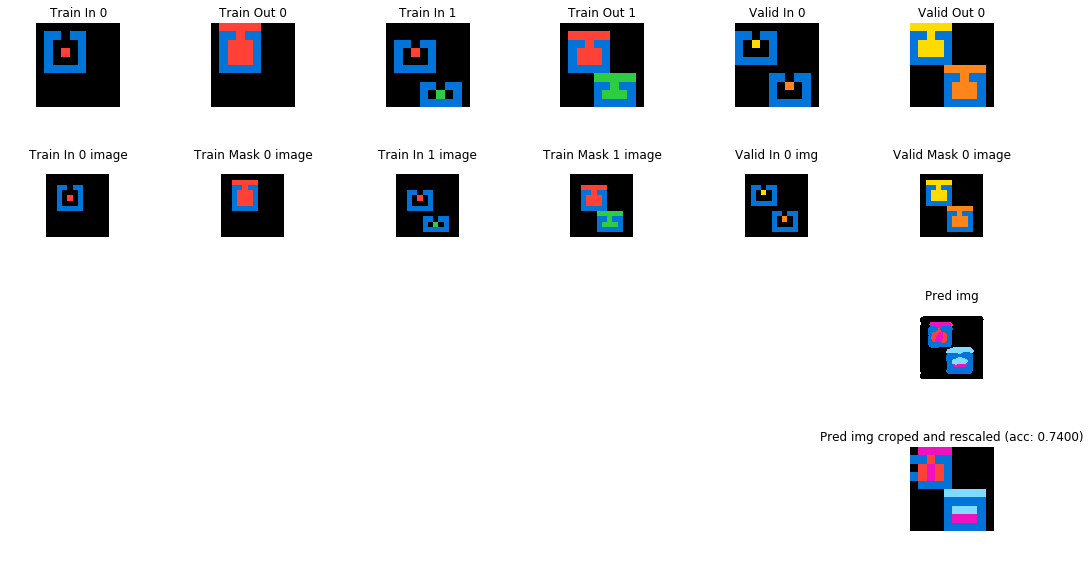

Task 4612dd53 start..
run #0 done
run #1 done


Accuracy 4612dd53_0: 0.9881656804733728


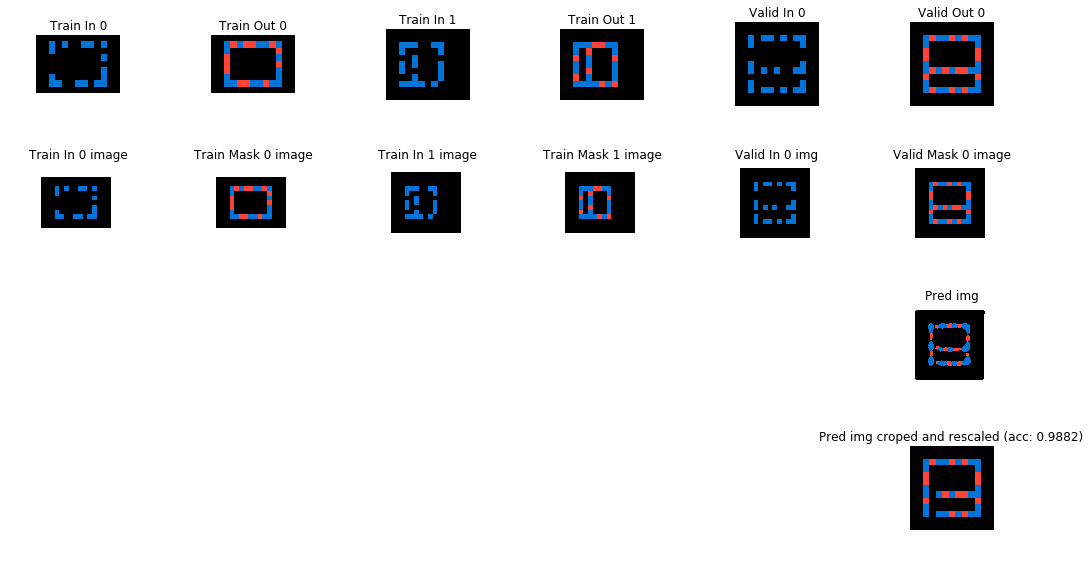

Task 50cb2852 start..
run #0 done
run #1 done


Accuracy 50cb2852_0: 0.8351648351648352


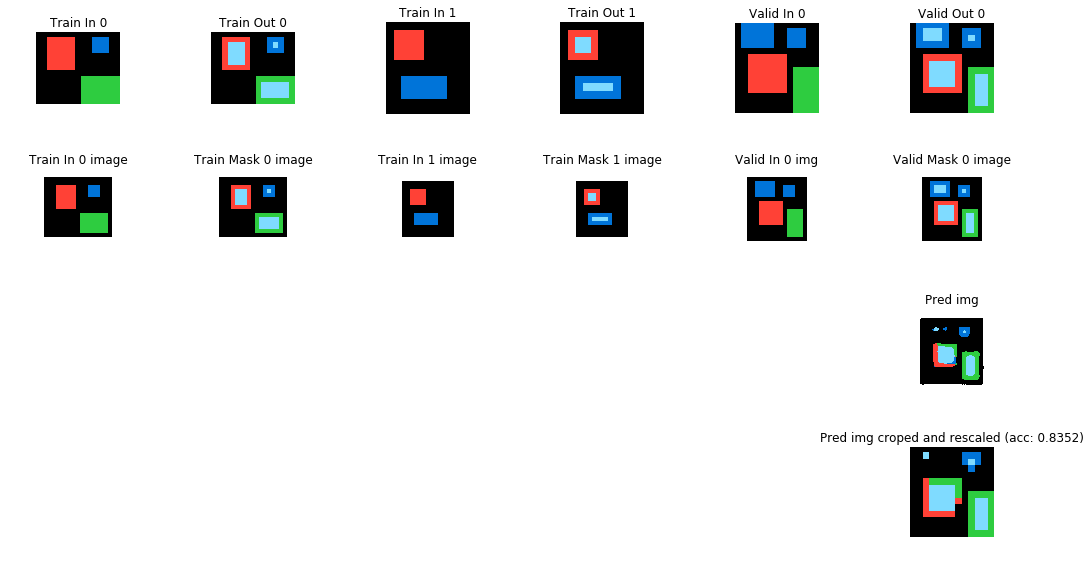

Task 60b61512 start..
run #0 done
run #1 done


Accuracy 60b61512_0: 0.9382716049382716


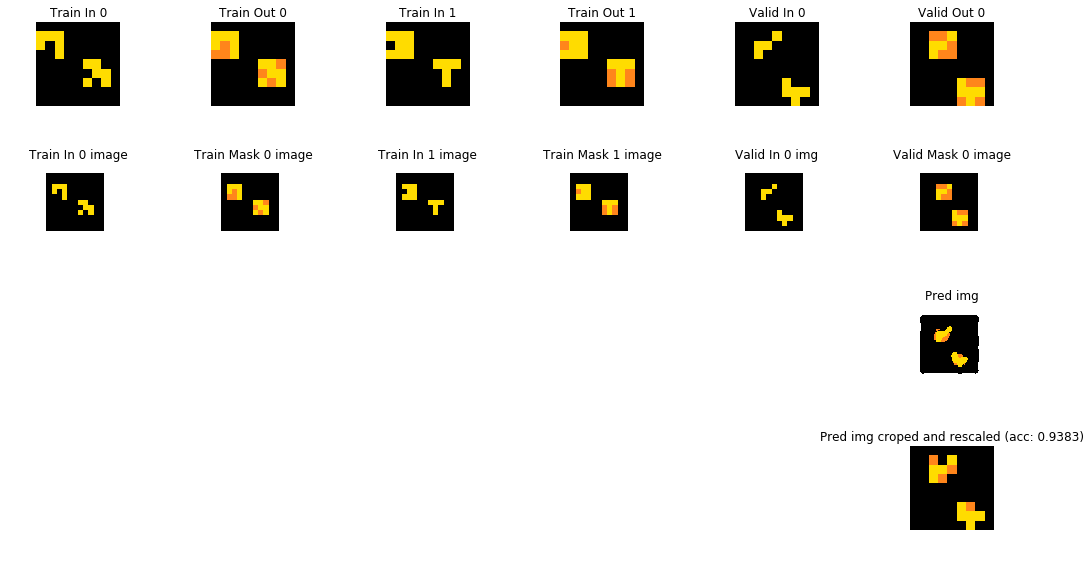

Task 67385a82 start..
run #1 done


Accuracy 694f12f3_0: 0.96


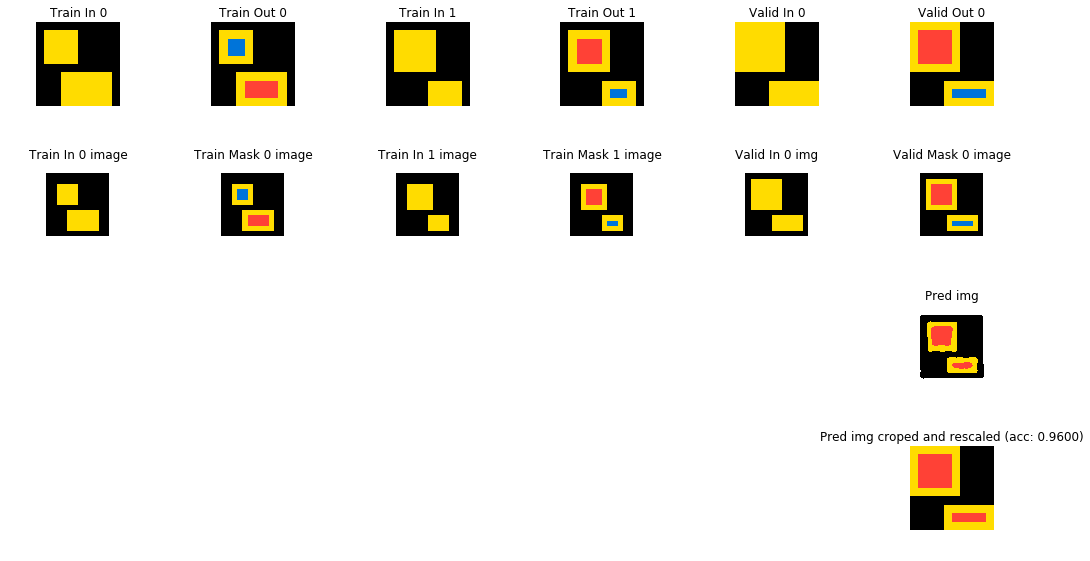

Task 6c434453 start..
run #0 done
run #0 done
run #1 done


Accuracy 6e82a1ae_0: 0.95


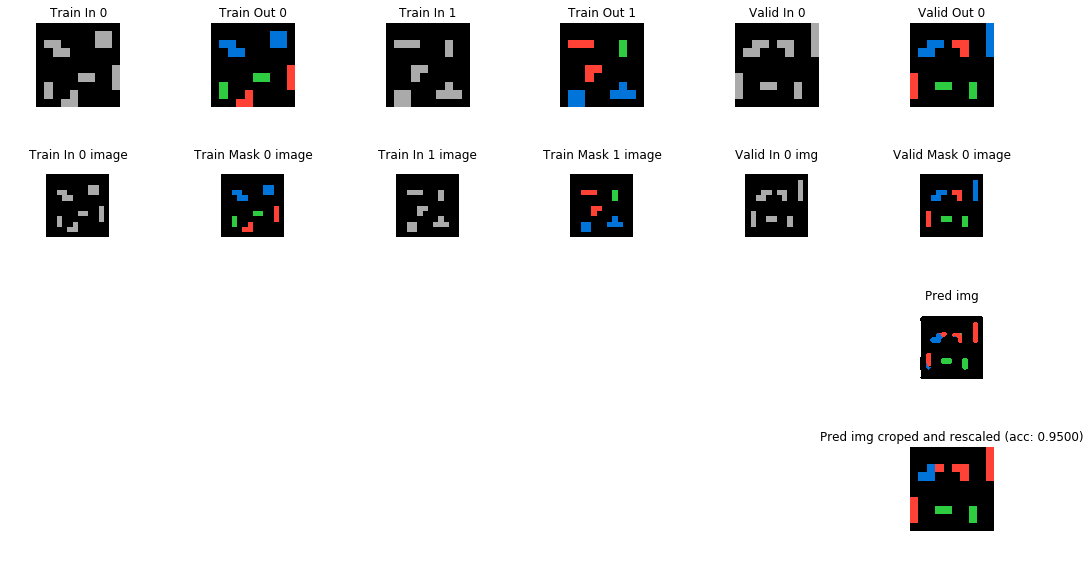

Done !
CPU times: user 28min 12s, sys: 22min 44s, total: 50min 57s
Wall time: 1h 16min


In [13]:
%%time
measures = []

for taskname in training_tasks:
    try:
        l = learn(taskname, epochs = 150, runs = 2, lr = 5e-5) #e150 r2
        t = l.TTA(ds_type=DatasetType.Valid, beta=0.7) # l.get_preds(ds_type=DatasetType.Valid) #
            
        ## loop over all predictions
        pred_imgs=[]
        acc_avg = 0
        for p in range(t[0].shape[0]):
            pred_img = t[0][p].numpy().argmax(axis = 0)
            pred_imgs.append(pred_img)
            # zoom to expected size
            rs_pred_img = resize_unpad(pred_img,task_info[taskname]['max_xy'],
                                       np.round(task_info[taskname]['test_in_shapes'][p] * 
                                                task_info[taskname]['avg_train_shape_factor']).astype('uint8'))
            
            # evaluate
            y_img = task_sample_arr(taskname, test_train = 'test', in_out = 'output', idx = p).reshape(1,-1)[0]
            y_hat_img = rs_pred_img.reshape(1,-1)[0]
            
            acc = metrics.accuracy_score(y_img, y_hat_img)
            print(f"Accuracy {taskname}_{p}: {acc}")
            
            acc_avg = (acc_avg * (p) + acc) / (p+1)
        
        measures += [[taskname , round(acc_avg, 4)]]
        plot_task(taskname, pred_imgs=pred_imgs, max_train = 2)
        
    except:
        measures += [[taskname , np.nan]]
        plt.show()
        print('Exception occured!')

pd.DataFrame(measures, columns=['taskname', 'accuracy_unet']).to_csv(f'evaluation_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv', index = False)

print('Done !')